## CAPTURE SATELLITE IMAGES FOR PAST PERIOD WITH LANDSAT-5 (1984 - 2000)

Notebook written for the most part by <a href="https://github.com/Jesshuan">Jesshuan</a> with my own small modifications

In [1]:
import ee
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import time
from datetime import date
import json
from json import JSONEncoder

Authentification with Google Engine :

Run cell, click link and follow instuctions (with connected google account and initiating an Earth Engine project) to get a token and copy/paste it below.

In [ ]:
ee.Authenticate()
ee.Initialize()
print(ee.Image("NASA/NASADEM_HGT/001").get("title").getInfo())

-----------

IMPORT AND MANAGE DATA :

In [3]:
data = pd.read_excel('data/data_parcelles_with_gps.xlsx')

In [4]:
data_used = data[['PARCELLE','LAT', 'LON','DATE','LFI']]

Collection campaign filtering :

In [5]:
LFI = 'LFI2'

data_used = data_used.loc[data_used['LFI']==LFI,:]

Code for a test on few lines :

In [6]:
#data_used = data_used[0:5]

Code for a problematic relaunch (to filter the dataset with the problematic parcelles list) :

In [6]:
#pb_list_df = pd.read_csv('data/Problematic_plots.csv')
#pb_list = pb_list_df['Problematic plots'].to_list()
#data_used = data_used.loc[data_used['PARCELLE'].isin(pb_list),:]

--------------------------

CLASS FOR EXCEPTIONS :

In [7]:
class NoImage(Exception):
    def __init__(self, nb_image):
        self.__nb_image = nb_image

    @property
    def nb_image(self):
        return self.__nb_image

In [8]:
class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        if isinstance(obj, (datetime, date)):
            return str(obj)
        return json.JSONEncoder.default(self, obj)

FUNCTIONS (FOR LANDSAT-5 & 7):

In [9]:
def NDVI(img): #finds vegetation
    img = ee.Image(img.normalizedDifference(['B4', 'B3'])).rename(["ndvi"])
    return img

def EVI(img): #idem NDVI, more reliable and precise in theory
    img = ee.Image(img.expression(
        '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
            'NIR': img.select('B4').divide(10000),
            'RED': img.select('B3').divide(10000),
            'BLUE': img.select('B1').divide(10000)
        })).rename(["evi"])
    
    return img

def NDMI(img): #finds water content in vegetation 
    #img = ee.Image(img.normalizedDifference(['B8', 'B11'])).rename(["ndmi"])
    img = ee.Image(img.expression(
        '(NIR - SWITCH) / (SWITCH + NIR)', {
            'NIR': img.select('B4').divide(10000),
            'SWITCH': img.select('B5').divide(10000)
       })).rename(["ndmi"])
    return img

def NDWI(img): #surface water content
    #img = ee.Image(img.normalizedDifference(['B3', 'B8'])).rename(["ndwi"])
    img = ee.Image(img.expression(
        '(GREEN - NIR) / (GREEN + NIR)', {
            'NIR': img.select('B4').divide(10000),
            'GREEN': img.select('B2').divide(10000)
        })).rename(["ndwi"])
    return img


def DSWI(img): # Disease Water Stress Index sensitive to stress due to water shortage and plant damage
    img = ee.Image(img.expression(
        '(NIR - GREEN) / (SWIR1 + RED)', {
            'NIR': img.select('B4').divide(10000),
            'RED': img.select('B3').divide(10000),
            'GREEN': img.select('B2').divide(10000),
            'SWIR1': img.select('B5').divide(10000),
        })).rename(["dswi"])
    
    return img

def B1(img):
    b2 = ee.Image(img.select(['B1'])).divide(10000).rename(["b1"])
    return b2

def B2(img):
    b2 = ee.Image(img.select(['B2'])).divide(10000).rename(["b2"])
    return b2

def B3(img):
    b3 = ee.Image(img.select(['B3'])).divide(10000).rename(["b3"])
    print('add b3')
    return b3

def B4(img):
    b4 = ee.Image(img.select(['B4'])).divide(10000).rename(["b4"])
    return b4

def B5(img):
    b5 = ee.Image(img.select(['B5'])).divide(10000).rename(["b5"])
    return b5

In [10]:
def collection_to_array(lat_loc, lon_loc, date_dep, date_fin):
    global dim_image, percentage_max_cloud_cover, Spectral_Band_init, Spectral_Functions, Satellite
    pas_lat = dim_image/111120
    pas_lon = dim_image/111120

    area = ee.Geometry.BBox(lon_loc - pas_lon/2, lat_loc-pas_lat/2, lon_loc + pas_lon/2, lat_loc + pas_lat/2)
    pas_lon_cos = dim_image/(111120 * np.cos(lat_loc*np.pi/180))
    area_cos = ee.Geometry.BBox(lon_loc - pas_lon_cos/2, lat_loc-pas_lat/2, lon_loc + pas_lon_cos/2, lat_loc + pas_lat/2)

    collection = ee.ImageCollection(Satellite).filterBounds(area_cos) \
                                      .filterDate(date_dep,date_fin) \
                                      #.filterMetadata("CLOUDY_PIXEL_PERCENTAGE","less_than",percentage_max_cloud_cover)\
                                      #.select(Spectral_Band_init) \
                                      
                                      
    print('collection')
    nb_images = collection.size().getInfo()
    print(f'{nb_images} images found...')

    if nb_images == 0:
        raise NoImage(nb_images)

    im_dict = dict()

    
    for _, funct in enumerate(Spectral_Functions):
        myCollection  = collection.map(Spectral_Functions.get(funct))
        img = ee.Image(myCollection.mean()).rename(['result'])
        img = img.addBands(ee.Image.pixelLonLat())
        img = img.reduceRegion(reducer=ee.Reducer.toList(),\
                                        geometry=area,\
                                        maxPixels=1e8,\
                                        scale=1)
        data = np.array((ee.Array(img.get('result')).getInfo()))
        lats = np.array((ee.Array(img.get("latitude")).getInfo()))
        lons = np.array((ee.Array(img.get("longitude")).getInfo()))
        uniqueLats = np.unique(lats)
        uniqueLons = np.unique(lons)
        ncols = len(uniqueLons)
        nrows = len(uniqueLats)
        arr = np.zeros([nrows, ncols], np.float32)
        counter =0
        for y in range(0,len(arr),1):
            for x in range(0,len(arr[0]),1):
                if lats[counter] == uniqueLats[y] and lons[counter] == uniqueLons[x] and counter < len(lats)-1:
                    counter+=1
                    arr[len(uniqueLats)-1-y,x] = data[counter]

        im_dict[f'{funct}'] = arr

        if funct==NDVI:
            im_dict[f'TNDVI'] = np.sqrt(arr) + 0.5
    
    return im_dict
    

--------------

USER'S PARAMETERS :

In [11]:
Satellite = 'LANDSAT/LT05/C02/T1'

dim_image = 200 #mètres de côté

OTHERS PARAMETERS

Parameter for cloud cover percentage (filter) :

In [36]:
#percentage_max_cloud_cover = 100

Spectral band needs (for functions) :

In [37]:
#Spectral_Band_init = ['B2', 'B3', 'B4', 'B5']

Important : keep dict format

In [12]:
Spectral_Functions = {'NDVI':NDVI, 'EVI':EVI, 'NDMI':NDMI, 'NDWI':NDWI, 'DSWI':DSWI}

Half of temporal open (centered on June 30th) :

In [15]:
days = 30

Image collection will be done between [center - days] and [center + days].

------------

IMAGES CAPTURE :

In [16]:
data_lfi = data_used.loc[data_used['LFI']==LFI,:]
data_lfi['YEAR'] = data_lfi['DATE'].map(lambda d : d.year)
if LFI=='LFI1':
    data_lfi['YEAR'] = data_lfi['YEAR'].map(lambda d: 1984 if d==1983 else d)
print (f"For campaign {LFI}, all the images will be extracted for year : {data_lfi['YEAR'].unique()}...")

# --- FORCE TEST YEAR --- 
#data_lfi['YEAR'] = 1990

#data_lfi = data_lfi[0:5]

# --- END TEST ---

nb_lines = len(data_lfi)
matrix_data = np.matrix(data_lfi)

Stock_images_list =dict()
Problem_list = []

for i in range(nb_lines):
    deb_image = time.time()
    parc_name = matrix_data.item(i, 0)
    print(f'--- PARCELLE {matrix_data.item(i, 0)} ---')
    parc_dict=dict()
    date_image = datetime.datetime.strptime(str(matrix_data.item(i, 5)) + '-06-30', '%Y-%m-%d')
    date_dep = (date_image - datetime.timedelta(days=days))
    date_fin = (date_image + datetime.timedelta(days=days))
    date_dep_string = str(date_dep.year) + '-' + str(date_dep.month) + '-' + str(date_dep.day)
    date_fin_string = str(date_fin.year) + '-' + str(date_fin.month) + '-' + str(date_fin.day)
    lat_loc = matrix_data.item(i, 1)
    lon_loc = matrix_data.item(i, 2)

    try:
        dict_images = collection_to_array(lat_loc, lon_loc, date_dep, date_fin)
    except NoImage:
        date_dep -= datetime.timedelta(days=days)
        date_fin += datetime.timedelta(days=days)
        print(f'Zero images for plot {parc_name}... so we tried with an open of {days*4} days...')
        try:
            dict_images = collection_to_array(lat_loc, lon_loc, date_dep, date_fin)
        except NoImage:
            date_dep -= datetime.timedelta(days=days)
            date_fin += datetime.timedelta(days=days)
            print(f'Zero images for plot {parc_name}... so we tried with an open of {days*8} days...')
            try:
                dict_images = collection_to_array(lat_loc, lon_loc, date_dep, date_fin)
            except:
                print(f'--- PROBLEM ! with plot {parc_name}... ---')
                dict_images = np.nan
                Problem_list.append(parc_name)
        except:
            print(f'--- PROBLEM ! with plot {parc_name}... ---')
            dict_images = np.nan
            Problem_list.append(parc_name)
    except:
        print(f'--- PROBLEM ! with plot {parc_name}... ---')
        dict_images = np.nan
        Problem_list.append(parc_name)


    parc_dict['PARCELLE'] = matrix_data.item(i, 0)
    parc_dict['LAT, LON'] = (lat_loc, lon_loc)
    parc_dict['DATE_INIT'] = str(matrix_data.item(i, 3))
    parc_dict['LFI'] = matrix_data.item(i, 4)
    parc_dict['DATE_IMAGE_SAT'] = str(date_image)
    parc_dict['IMAGES_SAT'] = dict_images
    Stock_images_list[f'{matrix_data.item(i, 0)}'] = parc_dict
    fin_image = time.time()
    print(f'This image processing took {round(fin_image - deb_image,4)} seconds... ')

print('Finished !...')
print(f'But we have a problem with this list of plots : {Problem_list}')


For campaign LFI2, all the images will be extracted for year : [1993]...
--- PARCELLE 114309 ---
collection
10 images found...
This image processing took 18.8991 seconds... 
--- PARCELLE 114313 ---
collection
10 images found...
This image processing took 16.5006 seconds... 
--- PARCELLE 115509 ---
collection
10 images found...
This image processing took 17.011 seconds... 
--- PARCELLE 115517 ---
collection
6 images found...
This image processing took 17.9005 seconds... 
--- PARCELLE 116705 ---
collection
10 images found...
This image processing took 17.8028 seconds... 
--- PARCELLE 116713 ---
collection
6 images found...
This image processing took 19.3415 seconds... 
--- PARCELLE 117909 ---
collection
10 images found...
This image processing took 17.8536 seconds... 
--- PARCELLE 119120 ---
collection
6 images found...
This image processing took 17.0169 seconds... 
--- PARCELLE 124960 ---
collection
10 images found...
This image processing took 26.2848 seconds... 
--- PARCELLE 127253 --

### Exportation of files :

Custom splitting :

In [20]:
nb_parts = 8 # to define number of parts of the unique dict

In [21]:
Decoup_stock_images = []

len_sub_list = len(Stock_images_list)//nb_parts

for i in range(nb_parts-1):
    Decoup_stock_images.append(dict(list(Stock_images_list.items())[i*len_sub_list:(i+1)*len_sub_list]))
Decoup_stock_images.append(dict(list(Stock_images_list.items())[(nb_parts-1)*len_sub_list:]))

In [57]:
for i in range(nb_parts):
    print(f'... Exportation of dict n°{i+1} (length : {len(Decoup_stock_images[i])}) in a jsonfile...')
    list_json = json.dumps(Decoup_stock_images[i], cls=NumpyArrayEncoder)
    with open(f"data/Images_{Satellite.split('/')[0].split('-')[0]}_{LFI}_part{i+1}.json", "w") as f:
        f.write(list_json)
    print(f'... Exportation dict n°{i+1} done...')

... Exportation of dict n°1 (length : 300) in a jsonfile...
... Exportation dict n°0 done...
... Exportation of dict n°2 (length : 300) in a jsonfile...
... Exportation dict n°1 done...
... Exportation of dict n°3 (length : 300) in a jsonfile...
... Exportation dict n°2 done...
... Exportation of dict n°4 (length : 300) in a jsonfile...
... Exportation dict n°3 done...
... Exportation of dict n°5 (length : 300) in a jsonfile...
... Exportation dict n°4 done...
... Exportation of dict n°6 (length : 300) in a jsonfile...
... Exportation dict n°5 done...
... Exportation of dict n°7 (length : 300) in a jsonfile...
... Exportation dict n°6 done...
... Exportation of dict n°8 (length : 303) in a jsonfile...
... Exportation dict n°7 done...


One file :

In [17]:
print('... Exportation in a jsonfile...')

list_json = json.dumps(Stock_images_list, cls=NumpyArrayEncoder)
with open(f"data/Images_{Satellite.split('/')[0].split('-')[0]}_{LFI}_pb1.json", "w") as f:
    f.write(list_json)

print('... Exportation done...')

... Exportation in a jsonfile...
... Exportation done...


Problem list :

In [27]:
print('... Exportation of the problematic plot\'s list in a text...')

df_pb_list = pd.DataFrame(Problem_list, columns=['Problematic plots'])
df_pb_list.to_csv('data/Problematic_plots.csv')

print('...Exportation done...')

... Exportation of the problematic plot's list in a text...
...Exportation done...


---------------

Test opening file :

In [19]:
with open(f"data/Images_{Satellite.split('/')[0].split('-')[0]}_{LFI}_part1.json", "r") as f:
 
    json_object = json.load(f)

In [59]:
json_object['1419'].get('DATE_INIT')

'1995-09-28 00:00:00'

In [60]:
json_object['1419'].get('DATE_IMAGE_SAT')

'1995-06-30 00:00:00'

In [61]:
json_object['1419'].get('LAT, LON')

[47.66018830721868, 8.996233931629856]

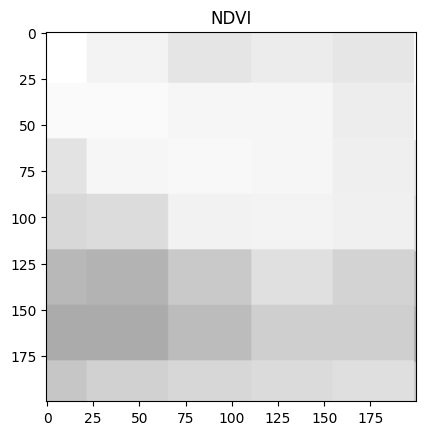

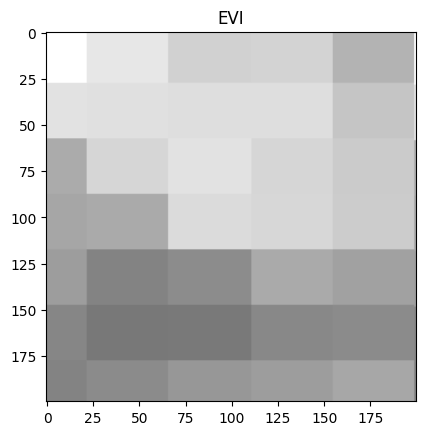

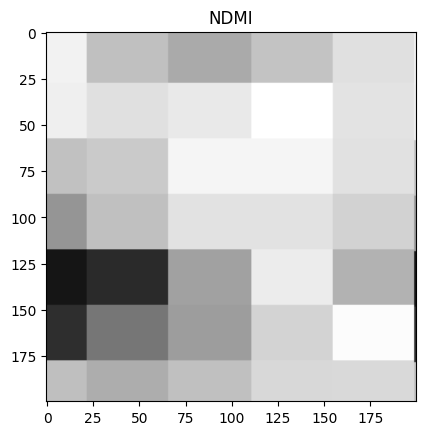

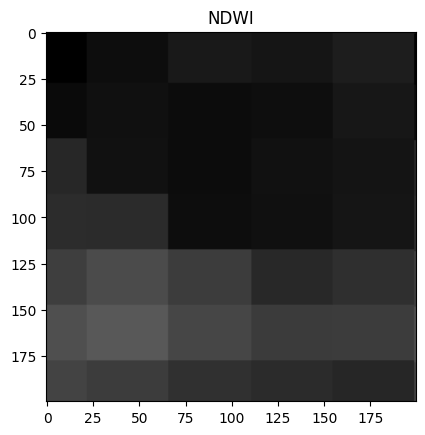

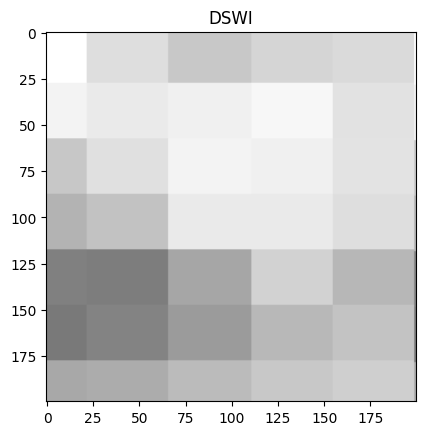

In [62]:
for _, funct in enumerate(json_object['1419'].get('IMAGES_SAT')):
    plt.title(f'{funct}')
    plt.imshow(json_object['1419'].get('IMAGES_SAT').get(funct), 'gray')
    plt.show()